In [195]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
import numpy as np
import pandas as pd
import os 
from tensorflow.keras.optimizers import Adam

In [176]:
import pandas as pd
import numpy as np

# Load CSV without attempting to parse dates yet
df = pd.read_csv("C:/Users/awodo/Downloads/FINALYEAR_cleaned.csv")

# Manually drop rows where 'Time' column is literally the word "Time"
df = df[df['Time'] != 'Time']

# Convert 'Time' to datetime, coercing errors to NaT
df['Time'] = pd.to_datetime(df['Time'], errors='coerce')

# Drop rows where datetime conversion failed
df = df.dropna(subset=['Time'])

# Create hour and time_of_day columns
df['hour'] = df['Time'].dt.hour
#df['time_of_day'] = df['hour'].apply(lambda x: 1 if (8 <= x <= 20) else 0)  # peak hours

# Trigonometric (cyclical) encoding of hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Select features
selected = ["Total_Power", "hour_sin", "hour_cos", "Anomaly"]
df = df[selected]

# Preview
print(df.tail())
df.head()

      Total_Power  hour_sin  hour_cos  Anomaly
1003           15 -0.707107  0.707107        0
1004           15 -0.500000  0.866025        0
1005           15 -0.500000  0.866025        0
1006           15 -0.258819  0.965926        0
1007           15 -0.258819  0.965926        0


C:\Users\awodo\AppData\Local\Temp\ipykernel_13732\2110456315.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')


,Total_Power,hour_sin,hour_cos,Anomaly
0,15,0.000000,1.000000,0
1,15,0.000000,1.000000,0
2,15,0.258819,0.965926,0
3,15,0.258819,0.965926,0
4,15,0.500000,0.866025,0


In [177]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

TIME_STEPS = 6

# ----- STEP 2: Select and scale features -----
# Select columns including trig features
df_selected = df[['Total_Power', 'hour_sin', 'hour_cos', 'Anomaly']].copy()

# Scale only continuous features (Total_Power, time_of_day, hour_sin, hour_cos)
scaler = MinMaxScaler()
df_selected[['Total_Power', 'hour_sin', 'hour_cos']] = scaler.fit_transform(
    df_selected[['Total_Power', 'hour_sin', 'hour_cos']]
)

# Leave Anomaly as is (0 or 1)

def create_sequences(data, time_steps=TIME_STEPS):
    X, y_power, y_anomaly = [], [], []
    for i in range(len(data) - time_steps - 1):
        seq_x = data.iloc[i:i+time_steps][['Total_Power', 'hour_sin', 'hour_cos', 'Anomaly']].values
        X.append(seq_x)
        y_power.append(data.iloc[i + time_steps + 1]['Total_Power'])   # target power at next step
        y_anomaly.append(data.iloc[i + time_steps + 1]['Anomaly'])     # target anomaly at next step
    return np.array(X), np.array(y_power), np.array(y_anomaly)

X, y_power, y_anomaly = create_sequences(df_selected)

print('X shape:', X.shape)        # (samples, TIME_STEPS, 5)
print('y_power shape:', y_power.shape)  # (samples,)
print('y_anomaly shape:', y_anomaly.shape)  # (samples,)

# ----- STEP 4: Split into train/val/test -----
X_train_val, X_test, y_power_train_val, y_power_test, y_anomaly_train_val, y_anomaly_test = train_test_split(
    X, y_power, y_anomaly, test_size=0.15, random_state=42
)

X_train, X_val, y_power_train, y_power_val, y_anomaly_train, y_anomaly_val = train_test_split(
    X_train_val, y_power_train_val, y_anomaly_train_val, test_size=0.1765, random_state=42
)

print('Train shape:', X_train.shape)
print('Val shape:', X_val.shape)
print('Test shape:', X_test.shape)


X shape: (1001, 6, 4)
y_power shape: (1001,)
y_anomaly shape: (1001,)
Train shape: (699, 6, 4)
Val shape: (151, 6, 4)
Test shape: (151, 6, 4)


In [178]:
from sklearn.model_selection import train_test_split

# Split off test set (10%)
X_temp, X_test, y_power_temp, y_power_test, y_anomaly_temp, y_anomaly_test = train_test_split(
    X, y_power, y_anomaly, test_size=0.3, random_state=42)

# Split remaining into train (80%) and val (20% of temp)
X_train, X_val, y_power_train, y_power_val, y_anomaly_train, y_anomaly_val = train_test_split(
    X_temp, y_power_temp, y_anomaly_temp, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (560, 6, 4)
Val shape: (140, 6, 4)
Test shape: (301, 6, 4)


In [179]:
# Define model parameters
TIME_STEPS = 6
FEATURES = 4

In [180]:
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

input_layer = Input(shape=(TIME_STEPS, FEATURES))
# Stacked LSTM layers with more units
x = LSTM(256, return_sequences=True)(input_layer)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = LSTM(128, return_sequences=True)(input_layer)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = LSTM(128)(x)
x = Dropout(0.3)(x)


shared = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
shared = Dropout(0.4)(shared)
shared = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
shared = Dropout(0.4)(shared)
# Use sigmoid activation for anomaly output (binary classification)

power_output = Dense(16, activation='linear')(shared)
power_output = Dense(1, activation='linear', name='predicted_power')(shared)
anomaly_output = Dense(1, activation='sigmoid', name='predicted_anomaly')(shared)
model = Model(inputs=input_layer, outputs=[power_output, anomaly_output])
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={'predicted_power': 'mse', 'predicted_anomaly': 'binary_crossentropy'},
    loss_weights={'predicted_power': 1.0, 'predicted_anomaly': 1.5},
    metrics={'predicted_power': 'mae', 'predicted_anomaly': 'accuracy'}
)
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 6, 4)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_35 (LSTM)      │ (None, 6, 128)    │     68,096 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_57          │ (None, 6, 128)    │          0 │ lstm_35[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 128)    │        512 │ dropout_57[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_36 (LSTM)      │ (None, 128)       │    131,584 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_58          │ (None, 128)       │          0 │ lstm_36[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 128)       │     16,512 │ dropout_58[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_60          │ (None, 128)       │          0 │ dense_32[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predicted_power     │ (None, 1)         │        129 │ dropout_60[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predicted_anomaly   │ (None, 1)         │        129 │ dropout_60[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 216,962 (847.51 KB)

 Trainable params: 216,706 (846.51 KB)

 Non-trainable params: 256 (1.00 KB)

In [181]:
# --- Step 5: Train the model ---
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose = 1),
    ModelCheckpoint("best_model.h5", save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss',
                  factor=0.5,
                  patience=8,
                  min_lr=1e-6,
                  verbose=1)

]

In [182]:
import numpy as np

# Convert train data
X_train = np.array(X_train, dtype=np.float32)
y_power_train = np.array(y_power_train, dtype=np.float32)
y_anomaly_train = np.array(y_anomaly_train, dtype=np.float32)

# Convert validation data
X_val = np.array(X_val, dtype=np.float32)
y_power_val = np.array(y_power_val, dtype=np.float32)
y_anomaly_val = np.array(y_anomaly_val, dtype=np.float32)

# Convert test data
X_test = np.array(X_test, dtype=np.float32)
y_power_test = np.array(y_power_test, dtype=np.float32)
y_anomaly_test = np.array(y_anomaly_test, dtype=np.float32)

# Print shapes and dtypes for verification
print(f"X_train: shape={X_train.shape}, dtype={X_train.dtype}")
print(f"y_power_train: shape={y_power_train.shape}, dtype={y_power_train.dtype}")
print(f"y_anomaly_train: shape={y_anomaly_train.shape}, dtype={y_anomaly_train.dtype}")

print(f"X_val: shape={X_val.shape}, dtype={X_val.dtype}")
print(f"y_power_val: shape={y_power_val.shape}, dtype={y_power_val.dtype}")
print(f"y_anomaly_val: shape={y_anomaly_val.shape}, dtype={y_anomaly_val.dtype}")

print(f"X_test: shape={X_test.shape}, dtype={X_test.dtype}")
print(f"y_power_test: shape={y_power_test.shape}, dtype={y_power_test.dtype}")
print(f"y_anomaly_test: shape={y_anomaly_test.shape}, dtype={y_anomaly_test.dtype}")


X_train: shape=(560, 6, 4), dtype=float32
y_power_train: shape=(560,), dtype=float32
y_anomaly_train: shape=(560,), dtype=float32
X_val: shape=(140, 6, 4), dtype=float32
y_power_val: shape=(140,), dtype=float32
y_anomaly_val: shape=(140,), dtype=float32
X_test: shape=(301, 6, 4), dtype=float32
y_power_test: shape=(301,), dtype=float32
y_anomaly_test: shape=(301,), dtype=float32


In [183]:
del history

In [184]:
history = model.fit(
    X_train,
    {
        'predicted_power': y_power_train,
        'predicted_anomaly': y_anomaly_train
    },
    validation_data=(X_val, {
        'predicted_power': y_power_val,
        'predicted_anomaly': y_anomaly_val
    }),
    epochs=60,
    batch_size=16,
    callbacks=callbacks  # optional
)


Epoch 1/60
32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9586 - predicted_anomaly_accuracy: 0.8684 - predicted_anomaly_loss: 0.4405 - predicted_power_loss: 0.1722 - predicted_power_mae: 0.3298

35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.9332 - predicted_anomaly_accuracy: 0.8769 - predicted_anomaly_loss: 0.4241 - predicted_power_loss: 0.1715 - predicted_power_mae: 0.3289 - val_loss: 0.9577 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.4565 - val_predicted_power_loss: 0.1501 - val_predicted_power_mae: 0.3448 - learning_rate: 0.0010
Epoch 2/60
32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3951 - predicted_anomaly_accuracy: 0.9922 - predicted_anomaly_loss: 0.0791 - predicted_power_loss: 0.1537 - predicted_power_mae: 0.3134

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.3967 - predicted_anomaly_accuracy: 0.9912 - predicted_anomaly_loss: 0.0817 - predicted_power_loss: 0.1516 - predicted_power_mae: 0.3107 - val_loss: 0.8328 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.3853 - val_predicted_power_loss: 0.1349 - val_predicted_power_mae: 0.3238 - learning_rate: 0.0010
Epoch 3/60
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3592 - predicted_anomaly_accuracy: 0.9843 - predicted_anomaly_loss: 0.0967 - predicted_power_loss: 0.0952 - predicted_power_mae: 0.2455

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.3589 - predicted_anomaly_accuracy: 0.9842 - predicted_anomaly_loss: 0.0974 - predicted_power_loss: 0.0940 - predicted_power_mae: 0.2439 - val_loss: 0.7098 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.3080 - val_predicted_power_loss: 0.1320 - val_predicted_power_mae: 0.3187 - learning_rate: 0.0010
Epoch 4/60
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3447 - predicted_anomaly_accuracy: 0.9789 - predicted_anomaly_loss: 0.1119 - predicted_power_loss: 0.0621 - predicted_power_mae: 0.1949

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.3430 - predicted_anomaly_accuracy: 0.9792 - predicted_anomaly_loss: 0.1110 - predicted_power_loss: 0.0618 - predicted_power_mae: 0.1945 - val_loss: 0.5886 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.2497 - val_predicted_power_loss: 0.1021 - val_predicted_power_mae: 0.2690 - learning_rate: 0.0010
Epoch 5/60
32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3249 - predicted_anomaly_accuracy: 0.9787 - predicted_anomaly_loss: 0.1092 - predicted_power_loss: 0.0506 - predicted_power_mae: 0.1843

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.3231 - predicted_anomaly_accuracy: 0.9790 - predicted_anomaly_loss: 0.1079 - predicted_power_loss: 0.0509 - predicted_power_mae: 0.1842 - val_loss: 0.5705 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.2332 - val_predicted_power_loss: 0.1129 - val_predicted_power_mae: 0.2896 - learning_rate: 0.0010
Epoch 6/60
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2820 - predicted_anomaly_accuracy: 0.9856 - predicted_anomaly_loss: 0.0871 - predicted_power_loss: 0.0453 - predicted_power_mae: 0.1696

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2826 - predicted_anomaly_accuracy: 0.9854 - predicted_anomaly_loss: 0.0876 - predicted_power_loss: 0.0453 - predicted_power_mae: 0.1696 - val_loss: 0.5215 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.2121 - val_predicted_power_loss: 0.0998 - val_predicted_power_mae: 0.2671 - learning_rate: 0.0010
Epoch 7/60
31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2567 - predicted_anomaly_accuracy: 0.9869 - predicted_anomaly_loss: 0.0791 - predicted_power_loss: 0.0365 - predicted_power_mae: 0.1517

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2602 - predicted_anomaly_accuracy: 0.9863 - predicted_anomaly_loss: 0.0811 - predicted_power_loss: 0.0372 - predicted_power_mae: 0.1530 - val_loss: 0.4545 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.1785 - val_predicted_power_loss: 0.0872 - val_predicted_power_mae: 0.2436 - learning_rate: 0.0010
Epoch 8/60
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2934 - predicted_anomaly_accuracy: 0.9812 - predicted_anomaly_loss: 0.1035 - predicted_power_loss: 0.0411 - predicted_power_mae: 0.1576

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2924 - predicted_anomaly_accuracy: 0.9813 - predicted_anomaly_loss: 0.1030 - predicted_power_loss: 0.0410 - predicted_power_mae: 0.1571 - val_loss: 0.4079 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.1556 - val_predicted_power_loss: 0.0790 - val_predicted_power_mae: 0.2290 - learning_rate: 0.0010
Epoch 9/60
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2838 - predicted_anomaly_accuracy: 0.9790 - predicted_anomaly_loss: 0.1026 - predicted_power_loss: 0.0372 - predicted_power_mae: 0.1508

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2831 - predicted_anomaly_accuracy: 0.9792 - predicted_anomaly_loss: 0.1022 - predicted_power_loss: 0.0372 - predicted_power_mae: 0.1508 - val_loss: 0.3568 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.1280 - val_predicted_power_loss: 0.0730 - val_predicted_power_mae: 0.2189 - learning_rate: 0.0010
Epoch 10/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2494 - predicted_anomaly_accuracy: 0.9833 - predicted_anomaly_loss: 0.0827 - predicted_power_loss: 0.0370 - predicted_power_mae: 0.1467

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2496 - predicted_anomaly_accuracy: 0.9833 - predicted_anomaly_loss: 0.0828 - predicted_power_loss: 0.0370 - predicted_power_mae: 0.1466 - val_loss: 0.3249 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.1208 - val_predicted_power_loss: 0.0558 - val_predicted_power_mae: 0.1832 - learning_rate: 0.0010
Epoch 11/60
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3826 - predicted_anomaly_accuracy: 0.9607 - predicted_anomaly_loss: 0.1764 - predicted_power_loss: 0.0336 - predicted_power_mae: 0.1416

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.3731 - predicted_anomaly_accuracy: 0.9625 - predicted_anomaly_loss: 0.1702 - predicted_power_loss: 0.0336 - predicted_power_mae: 0.1417 - val_loss: 0.2972 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.1087 - val_predicted_power_loss: 0.0493 - val_predicted_power_mae: 0.1728 - learning_rate: 0.0010
Epoch 12/60
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2369 - predicted_anomaly_accuracy: 0.9807 - predicted_anomaly_loss: 0.0813 - predicted_power_loss: 0.0344 - predicted_power_mae: 0.1433

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2375 - predicted_anomaly_accuracy: 0.9809 - predicted_anomaly_loss: 0.0817 - predicted_power_loss: 0.0345 - predicted_power_mae: 0.1433 - val_loss: 0.2950 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.1101 - val_predicted_power_loss: 0.0489 - val_predicted_power_mae: 0.1719 - learning_rate: 0.0010
Epoch 13/60
29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2122 - predicted_anomaly_accuracy: 0.9873 - predicted_anomaly_loss: 0.0679 - predicted_power_loss: 0.0337 - predicted_power_mae: 0.1418

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2194 - predicted_anomaly_accuracy: 0.9860 - predicted_anomaly_loss: 0.0729 - predicted_power_loss: 0.0335 - predicted_power_mae: 0.1408 - val_loss: 0.2871 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.1113 - val_predicted_power_loss: 0.0433 - val_predicted_power_mae: 0.1561 - learning_rate: 0.0010
Epoch 14/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2489 - predicted_anomaly_accuracy: 0.9830 - predicted_anomaly_loss: 0.0938 - predicted_power_loss: 0.0354 - predicted_power_mae: 0.1398 - val_loss: 0.2881 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.1160 - val_predicted_power_loss: 0.0398 - val_predicted_power_mae: 0.1471 - learning_rate: 0.0010
Epoch 15/60
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1930 - predicted_anomaly_accuracy: 0.9894 - predicted_anomaly_loss: 0.0614 - predicted_power_loss: 0.0314 - predicted_power_mae: 0.1363

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1958 - predicted_anomaly_accuracy: 0.9890 - predicted_anomaly_loss: 0.0634 - predicted_power_loss: 0.0313 - predicted_power_mae: 0.1360 - val_loss: 0.2773 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.1152 - val_predicted_power_loss: 0.0340 - val_predicted_power_mae: 0.1341 - learning_rate: 0.0010
Epoch 16/60
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2466 - predicted_anomaly_accuracy: 0.9736 - predicted_anomaly_loss: 0.1013 - predicted_power_loss: 0.0287 - predicted_power_mae: 0.1256

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2453 - predicted_anomaly_accuracy: 0.9741 - predicted_anomaly_loss: 0.1004 - predicted_power_loss: 0.0288 - predicted_power_mae: 0.1258 - val_loss: 0.2704 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.1127 - val_predicted_power_loss: 0.0334 - val_predicted_power_mae: 0.1363 - learning_rate: 0.0010
Epoch 17/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2022 - predicted_anomaly_accuracy: 0.9853 - predicted_anomaly_loss: 0.0717 - predicted_power_loss: 0.0317 - predicted_power_mae: 0.1356 - val_loss: 0.2758 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.1127 - val_predicted_power_loss: 0.0421 - val_predicted_power_mae: 0.1541 - learning_rate: 0.0010
Epoch 18/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1825 - predicted_anomaly_accuracy: 0.9874 - predicted_anomaly_loss: 0.0594 - predicted_power_loss: 0.0336 - predicted_power_mae: 0.1384 - val_loss: 0.2750 - val_predicted_ano

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1794 - predicted_anomaly_accuracy: 0.9856 - predicted_anomaly_loss: 0.0653 - predicted_power_loss: 0.0271 - predicted_power_mae: 0.1265 - val_loss: 0.2618 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.1176 - val_predicted_power_loss: 0.0284 - val_predicted_power_mae: 0.1207 - learning_rate: 0.0010
Epoch 21/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2342 - predicted_anomaly_accuracy: 0.9773 - predicted_anomaly_loss: 0.1034 - predicted_power_loss: 0.0274 - predicted_power_mae: 0.1271 - val_loss: 0.2623 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.1217 - val_predicted_power_loss: 0.0248 - val_predicted_power_mae: 0.1196 - learning_rate: 0.0010
Epoch 22/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2542 - predicted_anomaly_accuracy: 0.9716 - predicted_anomaly_loss: 0.1139 - predicted_power_loss: 0.0341 - predicted_power_mae: 0.1417 - val_loss: 0.2662 - val_predicted_ano

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2202 - predicted_anomaly_accuracy: 0.9818 - predicted_anomaly_loss: 0.0967 - predicted_power_loss: 0.0282 - predicted_power_mae: 0.1316 - val_loss: 0.2592 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.1212 - val_predicted_power_loss: 0.0273 - val_predicted_power_mae: 0.1210 - learning_rate: 0.0010
Epoch 24/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1311 - predicted_anomaly_accuracy: 0.9948 - predicted_anomaly_loss: 0.0386 - predicted_power_loss: 0.0285 - predicted_power_mae: 0.1297 - val_loss: 0.2621 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.1244 - val_predicted_power_loss: 0.0277 - val_predicted_power_mae: 0.1241 - learning_rate: 0.0010
Epoch 25/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2053 - predicted_anomaly_accuracy: 0.9791 - predicted_anomaly_loss: 0.0898 - predicted_power_loss: 0.0283 - predicted_power_mae: 0.1248

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2050 - predicted_anomaly_accuracy: 0.9792 - predicted_anomaly_loss: 0.0896 - predicted_power_loss: 0.0283 - predicted_power_mae: 0.1248 - val_loss: 0.2557 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.1227 - val_predicted_power_loss: 0.0253 - val_predicted_power_mae: 0.1200 - learning_rate: 0.0010
Epoch 26/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1794 - predicted_anomaly_accuracy: 0.9849 - predicted_anomaly_loss: 0.0720 - predicted_power_loss: 0.0308 - predicted_power_mae: 0.1330 - val_loss: 0.2577 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.1237 - val_predicted_power_loss: 0.0279 - val_predicted_power_mae: 0.1219 - learning_rate: 0.0010
Epoch 27/60
32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2133 - predicted_anomaly_accuracy: 0.9807 - predicted_anomaly_loss: 0.0952 - predicted_power_loss: 0.0319 - predicted_power_mae: 0.1318

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2111 - predicted_anomaly_accuracy: 0.9808 - predicted_anomaly_loss: 0.0940 - predicted_power_loss: 0.0315 - predicted_power_mae: 0.1313 - val_loss: 0.2518 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.1196 - val_predicted_power_loss: 0.0305 - val_predicted_power_mae: 0.1252 - learning_rate: 0.0010
Epoch 28/60
31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2315 - predicted_anomaly_accuracy: 0.9753 - predicted_anomaly_loss: 0.1109 - predicted_power_loss: 0.0284 - predicted_power_mae: 0.1276

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2272 - predicted_anomaly_accuracy: 0.9762 - predicted_anomaly_loss: 0.1080 - predicted_power_loss: 0.0285 - predicted_power_mae: 0.1278 - val_loss: 0.2419 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.1167 - val_predicted_power_loss: 0.0264 - val_predicted_power_mae: 0.1157 - learning_rate: 0.0010
Epoch 29/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1961 - predicted_anomaly_accuracy: 0.9807 - predicted_anomaly_loss: 0.0883 - predicted_power_loss: 0.0286 - predicted_power_mae: 0.1276 - val_loss: 0.2456 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.1212 - val_predicted_power_loss: 0.0249 - val_predicted_power_mae: 0.1176 - learning_rate: 0.0010
Epoch 30/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2150 - predicted_anomaly_accuracy: 0.9767 - predicted_anomaly_loss: 0.1035 - predicted_power_loss: 0.0264 - predicted_power_mae: 0.1235 - val_loss: 0.2459 - val_predicted_ano

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1543 - predicted_anomaly_accuracy: 0.9884 - predicted_anomaly_loss: 0.0644 - predicted_power_loss: 0.0272 - predicted_power_mae: 0.1257 - val_loss: 0.2412 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.1208 - val_predicted_power_loss: 0.0258 - val_predicted_power_mae: 0.1146 - learning_rate: 0.0010
Epoch 33/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1825 - predicted_anomaly_accuracy: 0.9803 - predicted_anomaly_loss: 0.0840 - predicted_power_loss: 0.0275 - predicted_power_mae: 0.1241 - val_loss: 0.2547 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.1293 - val_predicted_power_loss: 0.0273 - val_predicted_power_mae: 0.1203 - learning_rate: 0.0010
Epoch 34/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1867 - predicted_anomaly_accuracy: 0.9823 - predicted_anomaly_loss: 0.0906 - predicted_power_loss: 0.0231 - predicted_power_mae: 0.1156

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1868 - predicted_anomaly_accuracy: 0.9823 - predicted_anomaly_loss: 0.0906 - predicted_power_loss: 0.0231 - predicted_power_mae: 0.1158 - val_loss: 0.2309 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.1154 - val_predicted_power_loss: 0.0263 - val_predicted_power_mae: 0.1208 - learning_rate: 0.0010
Epoch 35/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1528 - predicted_anomaly_accuracy: 0.9836 - predicted_anomaly_loss: 0.0685 - predicted_power_loss: 0.0236 - predicted_power_mae: 0.1161 - val_loss: 0.2413 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.1216 - val_predicted_power_loss: 0.0282 - val_predicted_power_mae: 0.1207 - learning_rate: 0.0010
Epoch 36/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1699 - predicted_anomaly_accuracy: 0.9857 - predicted_anomaly_loss: 0.0787 - predicted_power_loss: 0.0263 - predicted_power_mae: 0.1231 - val_loss: 0.2469 - val_predicted_ano

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1481 - predicted_anomaly_accuracy: 0.9829 - predicted_anomaly_loss: 0.0703 - predicted_power_loss: 0.0229 - predicted_power_mae: 0.1149 - val_loss: 0.2262 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.1168 - val_predicted_power_loss: 0.0272 - val_predicted_power_mae: 0.1192 - learning_rate: 0.0010
Epoch 43/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1456 - predicted_anomaly_accuracy: 0.9883 - predicted_anomaly_loss: 0.0673 - predicted_power_loss: 0.0258 - predicted_power_mae: 0.1217 - val_loss: 0.2347 - val_predicted_anomaly_accuracy: 0.9786 - val_predicted_anomaly_loss: 0.1239 - val_predicted_power_loss: 0.0254 - val_predicted_power_mae: 0.1164 - learning_rate: 0.0010
Epoch 44/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2058 - predicted_anomaly_accuracy: 0.9785 - predicted_anomaly_loss: 0.1095 - predicted_power_loss: 0.0235 - predicted_power_mae: 0.1156 - val_loss: 0.2502 - val_predicted_ano

In [185]:
from sklearn.metrics import f1_score

# Predict probabilities on validation data first
y_anomaly_val_pred_probs = model.predict(X_val)[1]

best_thresh = 0.5
best_f1 = 0

for thresh in np.arange(0.1, 0.9, 0.05):
    preds = (y_anomaly_val_pred_probs > thresh).astype(int)
    f1 = f1_score(y_anomaly_val, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"Best anomaly threshold: {best_thresh}, F1: {best_f1}")

# Use best_thresh for test predictions
y_anomaly_test_pred = (model.predict(X_test)[1] > best_thresh).astype(int)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step
Best anomaly threshold: 0.5, F1: 0
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [186]:
results = model.evaluate(
    X_test,
    {
        'predicted_power': y_power_test,
        'predicted_anomaly': y_anomaly_test
    },
    batch_size=32,
    verbose=1
)

print("Test results:", results)
metrics={'predicted_power': 'mae', 'predicted_anomaly': 'accuracy'}


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1491 - predicted_anomaly_accuracy: 0.9906 - predicted_anomaly_loss: 0.0709 - predicted_power_loss: 0.0278 - predicted_power_mae: 0.1310
Test results: [0.226825550198555, 0.030675509944558144, 0.13313131034374237, 0.9800664186477661, 0.13327094912528992]


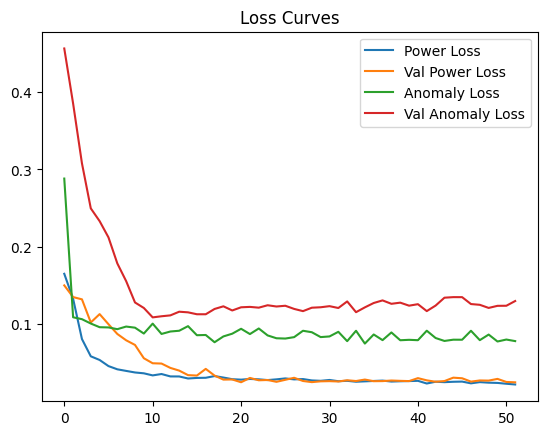

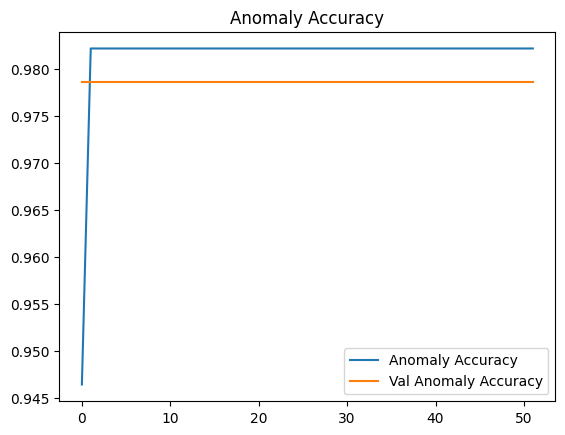

In [187]:
import matplotlib.pyplot as plt

# Losses
plt.plot(history.history['predicted_power_loss'], label='Power Loss')
plt.plot(history.history['val_predicted_power_loss'], label='Val Power Loss')
plt.plot(history.history['predicted_anomaly_loss'], label='Anomaly Loss')
plt.plot(history.history['val_predicted_anomaly_loss'], label='Val Anomaly Loss')
plt.legend()
plt.title("Loss Curves")
plt.show()

# Accuracy
plt.plot(history.history['predicted_anomaly_accuracy'], label='Anomaly Accuracy')
plt.plot(history.history['val_predicted_anomaly_accuracy'], label='Val Anomaly Accuracy')
plt.legend()
plt.title("Anomaly Accuracy")
plt.show()


In [188]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, accuracy_score

# --- Fit scaler only on power column (1D) ---
power_scaler = MinMaxScaler()
power_scaler.fit(df[['Total_Power']])

# --- Predict on test data ---
y_power_pred, y_anomaly_pred = model.predict(X_test)

# --- Inverse transform power predictions and ground truth ---
y_power_pred_orig = power_scaler.inverse_transform(y_power_pred.reshape(-1, 1))
y_power_test_orig = power_scaler.inverse_transform(y_power_test.reshape(-1, 1))
print(y_power_pred_orig, y_power_test_orig)

# --- Calculate MAE on original scale ---
mae = mean_absolute_error(y_power_test_orig, y_power_pred_orig)
print("Test MAE (original scale):", mae)

# --- For anomaly detection (binary output) ---
y_anomaly_pred_labels = (y_anomaly_pred > 0.5).astype(int)
acc = accuracy_score(y_anomaly_test, y_anomaly_pred_labels)
print("Anomaly detection accuracy:", acc)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[[21.993448 ]
 [26.861797 ]
 [15.80537  ]
 [21.818768 ]
 [14.686289 ]
 [17.439554 ]
 [16.1904   ]
 [30.880793 ]
 [15.8868475]
 [25.142172 ]
 [15.587232 ]
 [16.02633  ]
 [18.433826 ]
 [28.197063 ]
 [24.328497 ]
 [27.280798 ]
 [23.334597 ]
 [18.115635 ]
 [14.687975 ]
 [26.36231  ]
 [17.342815 ]
 [22.077843 ]
 [28.133318 ]
 [13.2628355]
 [18.512325 ]
 [14.215255 ]
 [15.8868475]
 [15.983398 ]
 [23.196629 ]
 [13.2628355]
 [19.216734 ]
 [17.194983 ]
 [13.848848 ]
 [18.619192 ]
 [29.971333 ]
 [16.679583 ]
 [15.687377 ]
 [20.374184 ]
 [13.2628355]
 [19.389544 ]
 [21.334524 ]
 [12.921755 ]
 [24.069677 ]
 [17.393974 ]
 [16.17251  ]
 [24.535784 ]
 [21.191256 ]
 [24.310698 ]
 [17.439554 ]
 [24.108063 ]
 [18.115635 ]
 [19.322212 ]
 [21.802382 ]
 [30.880793 ]
 [16.285553 ]
 [22.077843 ]
 [18.797403 ]
 [19.216734 ]
 [27.145714 ]
 [13.270926 ]
 [16.869356 ]
 [16.359491 ]
 [17.979435 ]
 [18.64641  ]
 [26.861797 ]
 [17.979435 ]
 [18.115635 ]
 [14.833431 ]
 [20.1180

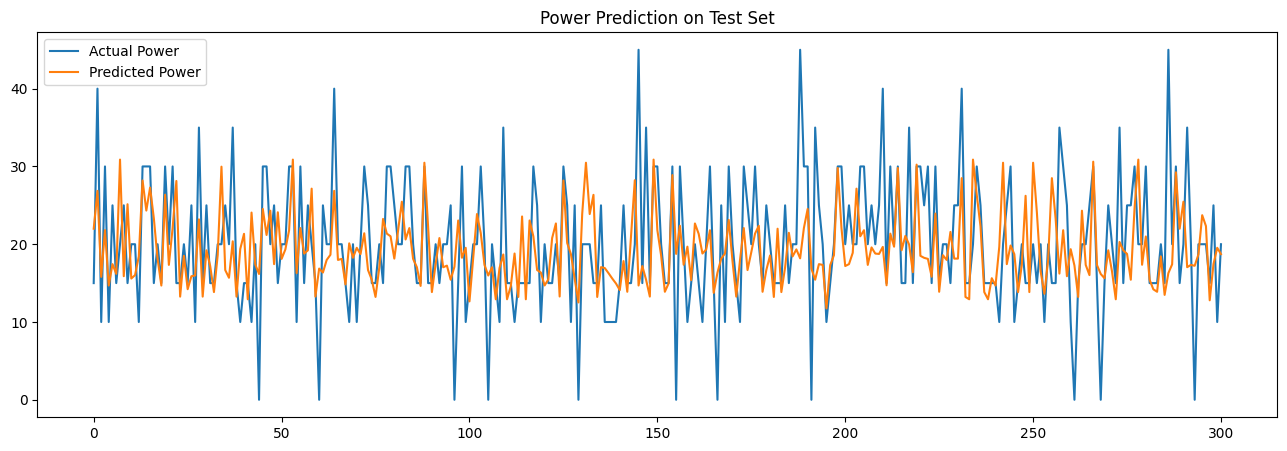

In [207]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(16, 5))
plt.plot(y_power_test_orig, label='Actual Power')
plt.plot(y_power_pred_orig, label='Predicted Power')
plt.legend()
plt.title('Power Prediction on Test Set')
plt.show()



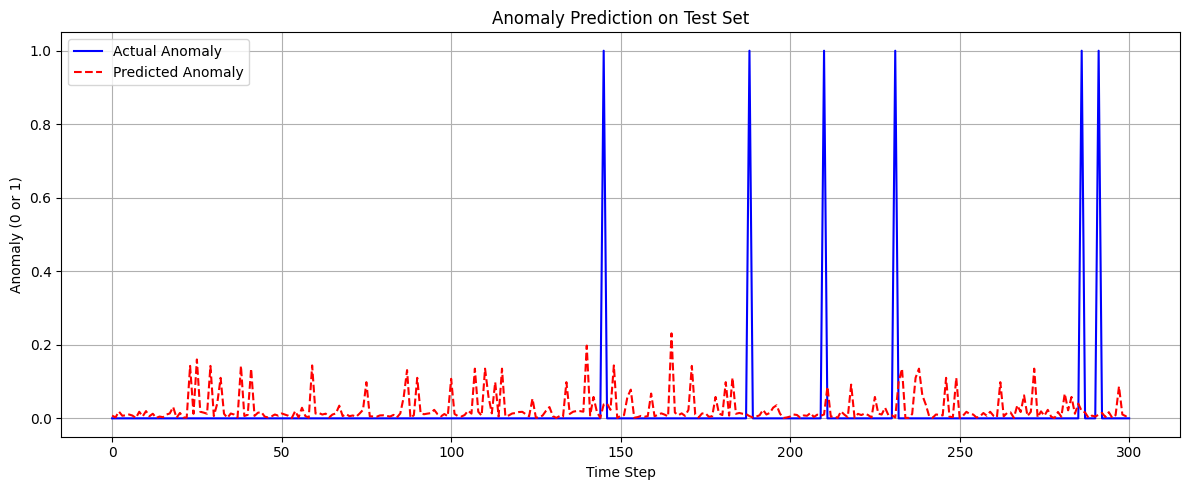

In [190]:
import matplotlib.pyplot as plt

# Basic Plot
plt.figure(figsize=(12, 5))  # Optional: Wider figure for better readability

# Plot actual anomaly labels
plt.plot(y_anomaly_test, label='Actual Anomaly', linestyle='-', color='blue')

# Plot predicted anomaly labels
plt.plot(y_anomaly_pred, label='Predicted Anomaly', linestyle='--', color='red')

# Add labels and title
plt.title('Anomaly Prediction on Test Set')
plt.xlabel('Time Step')
plt.ylabel('Anomaly (0 or 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [193]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_power_test_orig, y_power_pred_orig))
#rint(y_anomaly_pred)
print(f"Test RMSE (power): {rmse:.2f}, Anomaly Accuracy: {acc*100:.1f}%")

Test RMSE (power): 7.86, Anomaly Accuracy: 98.0%


In [205]:
import tensorflow as tf

# Method 1: Direct conversion (if model is still in memory)
# This is the cleanest approach - use this if your model is already trained and available
print("🔄 Converting model directly to TFLite...")

try:
    # Convert directly from the trained model without saving/loading
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    
    # LSTM-specific settings to handle TensorListReserve error
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS  # Enable TensorFlow ops for LSTM
    ]
    converter._experimental_lower_tensor_list_ops = False  # Disable tensor list lowering
    
    # Enable float16 quantization (good balance for ESP32)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]
    
    # Additional optimizations for multivariate models
    converter.allow_custom_ops = True  # In case of custom operations
    
    # Convert the model
    tflite_model = converter.convert()
    
    # Save the TFLite model
    with open("C:/Users/awodo/Downloads/FINALYEAR_model.tflite", "wb") as f:
        f.write(tflite_model)
    
    print("✅ Float16 TFLite model for multivariate prediction saved successfully!")
    
except Exception as e:
    print(f"❌ Direct conversion failed: {e}")
    print("🔄 Trying alternative method...")
    
    # Method 2: Save and load with proper custom objects
    try:
        # Save in the newer .keras format (better serialization)
        print("💾 Saving model in .keras format...")
        model.save("C:/Users/awodo/Downloads/FINALYEAR_model.keras")
        
        # Load the model
        print("📂 Loading model...")
        loaded_model = tf.keras.models.load_model("C:/Users/awodo/Downloads/FINALYEAR_model.keras")
        
        # Convert to TFLite
        print("🔄 Converting to TFLite...")
        converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
        
        # LSTM-specific settings to handle TensorListReserve error
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS,
            tf.lite.OpsSet.SELECT_TF_OPS  # Enable TensorFlow ops for LSTM
        ]
        converter._experimental_lower_tensor_list_ops = False  # Disable tensor list lowering
        
        # Enable float16 quantization
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.target_spec.supported_types = [tf.float16]
        converter.allow_custom_ops = True
        
        # Convert the model
        tflite_model = converter.convert()
        
        # Save the TFLite model
        with open("C:/Users/awodo/Downloads/FINALYEAR_model.tflite", "wb") as f:
            f.write(tflite_model)
        
        print("✅ Float16 TFLite model for multivariate prediction saved successfully!")
        
    except Exception as e2:
        print(f"❌ .keras format failed: {e2}")
        print("🔄 Trying .h5 format with custom objects...")
        
        # Method 3: Save as .h5 and load with custom objects
        try:
            # Save your model in .h5 format
            print("💾 Saving model in .h5 format...")
            model.save("C:/Users/awodo/Downloads/FINALYEAR_model.h5", save_format='h5')
            
            # Define custom objects to handle serialization issues
            custom_objects = {
                'mse': tf.keras.losses.MeanSquaredError(),
                'mean_squared_error': tf.keras.losses.MeanSquaredError(),
                'MeanSquaredError': tf.keras.losses.MeanSquaredError(),
                'mae': tf.keras.losses.MeanAbsoluteError(),
                'mean_absolute_error': tf.keras.losses.MeanAbsoluteError(),
                'rmse': tf.keras.metrics.RootMeanSquaredError(),
                'adam': tf.keras.optimizers.Adam(),
                'Adam': tf.keras.optimizers.Adam()
            }
            
            # Load the saved model with custom objects
            print("📂 Loading model with custom objects...")
            loaded_model = tf.keras.models.load_model(
                "C:/Users/awodo/Downloads/FINALYEAR_model.h5",
                custom_objects=custom_objects
            )
            
            # Set up the converter
            print("🔄 Converting to TFLite...")
            converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
            
            # LSTM-specific settings to handle TensorListReserve error
            converter.target_spec.supported_ops = [
                tf.lite.OpsSet.TFLITE_BUILTINS,
                tf.lite.OpsSet.SELECT_TF_OPS  # Enable TensorFlow ops for LSTM
            ]
            converter._experimental_lower_tensor_list_ops = False  # Disable tensor list lowering
            
            # Enable float16 quantization (good balance for ESP32)
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            converter.target_spec.supported_types = [tf.float16]
            converter.allow_custom_ops = True
            
            # For multivariate models, you might need these additional settings
            converter.experimental_new_converter = True
            
            # Convert the model
            tflite_model = converter.convert()
            
            # Save the TFLite model
            with open("C:/Users/awodo/Downloads/FINALYEAR_model.tflite", "wb") as f:
                f.write(tflite_model)
            
            print("✅ Float16 TFLite model for multivariate prediction saved successfully!")
            
        except Exception as e3:
            print(f"❌ All methods failed. Final error: {e3}")
            print("\n🔧 Troubleshooting suggestions:")
            print("1. Try recreating and training your model from scratch")
            print("2. Check your TensorFlow version: pip install tensorflow==2.15.0")
            print("3. Use quantization-aware training if the model is complex")

# Optional: Verify the converted model
try:
    print("\n🔍 Verifying the converted model...")
    
    # Load and check the TFLite model
    interpreter = tf.lite.Interpreter(model_path="C:/Users/awodo/Downloads/FINALYEAR_model.tflite")
    interpreter.allocate_tensors()
    
    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    print(f"📊 Model Info:")
    print(f"   Input shape: {input_details[0]['shape']}")
    print(f"   Input type: {input_details[0]['dtype']}")
    print(f"   Output shape: {output_details[0]['shape']}")
    print(f"   Output type: {output_details[0]['dtype']}")
    
    # Check file size
    import os
    file_size = os.path.getsize("C:/Users/awodo/Downloads/FINALYEAR_model.tflite")
    print(f"   File size: {file_size / 1024:.2f} KB")
    
    print("✅ Model verification completed!")
    
except Exception as e:
    print(f"⚠️  Verification failed: {e}")
    print("Model was saved but verification encountered issues.")

print("\n🎯 Your multivariate prediction model is ready for ESP32 deployment!")

🔄 Converting model directly to TFLite...
INFO:tensorflow:Assets written to: C:\Users\awodo\AppData\Local\Temp\tmpyj3xis_9\assets


INFO:tensorflow:Assets written to: C:\Users\awodo\AppData\Local\Temp\tmpyj3xis_9\assets


Saved artifact at 'C:\Users\awodo\AppData\Local\Temp\tmpyj3xis_9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 6, 4), dtype=tf.float32, name='keras_tensor_177')
Output Type:
  List[TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)]
Captures:
  2046517142800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2046517142224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2046517141456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2046517143568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2046517147600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2046517142992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2046517147216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2046517144528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2046517147792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  204651714625

c:\Users\awodo\Desktop\Works\LSTM\myenv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
